# Importing libraries

In [8]:
#sometimes needs to install/reinstall, only uncomment and run as necessary
#import sys
#!{sys.executable} -m pip install --user statsmodels

In [9]:
#general data imports
import numpy as np
import pylab
import sklearn
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import mysql.connector
import datetime
import MySQLdb
import pylab as pl
from scipy import stats
import statsmodels.api as sm
from math import sqrt
import copy

#### Calculate Mean, Standard Deviation, and create a histogram for each

# Linear Regression
#### Starting by defining functions to use later

In [10]:
#defining functions
#page 247 Figure 15.8 Variance and standard deviation
def variance(X): 
    """Assumes that X is a list of numbers. 
       Returns the standard deviation of X""" 
    mean = sum(X)/len(X) 
    tot = 0.0 
    for x in X: 
        tot += (x - mean)**2 
    return tot/len(X) 
     
def stdDev(X): 
    """Assumes that X is a list of numbers. 
       Returns the standard deviation of X""" 
    return variance(X)**0.5 

#page 379 Figure 22.6 Minkowski distance 
def minkowskiDist(v1, v2, p): 
    """Assumes v1 and v2 are equal-length arrays of numbers 
       Returns Minkowski distance of order p between v1 and v2""" 
    dist = 0.0 
    for i in range(len(v1)): 
        dist += abs(v1[i] - v2[i])**p 
    return dist**(1/p) 

#page 400 Figure 23.14 Scaling Attributes
def iScaleFeatures(vals,minVal,maxVal):
    """Assumes vals is a sequence of floats"""
    #minVal, maxVal = min(vals), max(vals)
    fit = pylab.polyfit([minVal, maxVal], [0, 1], 1)
    #print(pylab.polyval(fit, vals))
    return pylab.polyval(fit, vals)

#page 407 of book Figure 24.4 Functions for evaluating classifiers 
def accuracy(truePos, falsePos, trueNeg, falseNeg): 
    numerator = truePos + trueNeg 
    denominator = truePos + trueNeg + falsePos + falseNeg 
    return numerator/denominator 
 
def sensitivity(truePos, falseNeg): 
    try: 
        return truePos/(truePos + falseNeg) 
    except ZeroDivisionError: 
        return float('nan') 
     
def specificity(trueNeg, falsePos): 
    try: 
        return trueNeg/(trueNeg + falsePos) 
    except ZeroDivisionError: 
        return float('nan') 
     
def posPredVal(truePos, falsePos): 
    try: 
        return truePos/(truePos + falsePos) 
    except ZeroDivisionError: 
        return float('nan') 
     
def negPredVal(trueNeg, falseNeg): 
    try: 
        return trueNeg/(trueNeg + falseNeg) 
    except ZeroDivisionError: 
        return float('nan') 
        
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True): 
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg) 
    sens = sensitivity(truePos, falseNeg) 
    spec = specificity(trueNeg, falsePos) 
    ppv = posPredVal(truePos, falsePos) 
    if toPrint: 
        print(' Accuracy =', round(accur, 3)) 
        print(' Sensitivity =', round(sens, 3)) 
        print(' Specificity =', round(spec, 3)) 
        print(' Pos. Pred. Val. =', round(ppv, 3)) 
    return (accur, sens, spec, ppv)
    
#page 409 of book Figure 24.5 Build examples and divide data into training and test sets
def divide80_20(examples):
    sampleIndices = random.sample(range(len(examples)), len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

#page 422 of book Figure 24.15 Use logistic regression to predict Gender
def applyModel(model, testSet, label, prob = 0.5):
    #Create vector containing feature vectors for all test examples
    testFeatureVecs = [e.getScaledFeatures() for e in testSet] #getFeatures or getScaledFeatures as necessary
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

### Defining the FipCodeCombineStats class
##### Scaling is completed by this class for all feature and outcome variables

In [11]:
#combined stats class maps labels to features by FIP code
class FipCodeCombineStats(object):
    features = ('Median AQI', 'AQI 90 Percentile', 'Median Household Income','Hospital Rating')
    scaledFeatures = ('Scaled Median AQI', 'Scaled AQI 90 Percentile', 'Scaled Median Household Income','Scaled Hospital Rating')
    def __init__(self, fip, state, county, median_aqi, AQI_ninety_percentile, median_household_income_value,
                premature_deaths, population_estimate_value, low_birthweight, hospital_rating):
        self.fip = fip
        self.state = state
        self.county = county
        
        #outcomes
        self.premature_deaths = premature_deaths
        self.low_birthweight = low_birthweight
        
        #scaled outcomes by population
        #self.scaled_premature_deaths = premature_deaths/population_estimate_value
        #self.scaled_low_birthweight = low_birthweight/population_estimate_value
        
        #scaling outcomes by min/max values. This makes features from 0 to 1, making weight easier to compare
        self.scaled_premature_deaths = iScaleFeatures(premature_deaths,3219, 20484)
        self.scaled_low_birthweight = iScaleFeatures(low_birthweight, .039999999, .280000)
        
        #create the featureVec
        self.featureVec = [median_aqi, AQI_ninety_percentile, median_household_income_value, hospital_rating]
        
        #scale using iScaleFeatures based on min/max values.  This makes features from 0 to 1, making weight easier to compare
        scaled_median_aqi = iScaleFeatures(median_aqi,0,151)
        scaled_AQI_ninety_percentile = iScaleFeatures(AQI_ninety_percentile,4,200)
        scaled_median_household_income_value = iScaleFeatures(median_household_income_value,24868,122641)
        scaled_hospital_rating = iScaleFeatures(hospital_rating,1,5)
        self.scaledFeatureVec = [scaled_median_aqi, scaled_AQI_ninety_percentile, scaled_median_household_income_value,scaled_hospital_rating]
    
    def distance(self, other):
        return minkowskiDist(self.scaledFeatureVec,other.scaledFeatureVec) #featureVec or scaledFeatureVec as appropriate
    
    def getLabel(self):
        #change depending on which you are loading
        return self.scaled_premature_deaths
        #return self.scaled_low_birthweight
    
    def getFeatures(self):
        return self.featureVec
    
    def getScaledFeatures(self):
        return self.scaledFeatureVec

### Connecting to the database and building our datasets
##### Creating the hospital dictionary, and then using that to build a combined dictionary and list of FipCodeCombineStats objects

In [12]:
#get all the data into a dictionary and a list
#Starting the database connection and setting up default values
mydb = mysql.connector.connect(
  host="localhost",
  user="i501fa18_group5",
  passwd="*85E!4LfLQbQ",
  database="i501fa18_group5"
)

#blank arrays for classes
combinedDict = {}
combinedList = []
hospitalDict = {}

#query to get the hospital_rating and create a hospitalDict.  Fewer FIP codes reported this statistic, so we are running this seperately to not confuse the other outputs.
cursor = mydb.cursor()
query = ("SELECT avg(hospital_rating), fip FROM CombinedData group by fip HAVING AVG(hospital_rating) >= 0")
cursor.execute(query)
for row in cursor:
    hospitalDict[row[1]] = row[0]

#query for FipCodeToCounty, build class dictionary
query = ("SELECT fip, state, county, median_aqi, AQI_ninety_percentile, median_household_income_value, premature_deaths, population_estimate_value, low_birthweight FROM CombinedData where premature_deaths is not NULL and low_birthweight is not NULL")
cursor.execute(query)
for row in cursor:
    #adding in the hospital rating value
    #appending the average of all other FIP codes to remove NULLS
    hr = float(3.0131)
    if(hospitalDict.get(row[0])):
        hr = float(hospitalDict.get(row[0]))
    currentFip = FipCodeCombineStats(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],hr)
    combinedDict[row[0]] = currentFip
    combinedList.append(currentFip)
    
#check if it worked
print(combinedDict.get("56025").featureVec)
print(combinedList[100].scaledFeatureVec)

#close the database when you are done with it
mydb.close()

[41, 50, 57427, 3.0]
[0.4238410596026489, 0.4948979591836738, 0.2972292964315303, 0.5370249999999996]


#### Taking the FipCodeCombineStats dictionary and turning it in to a Pandas array of values.
##### Using the scaled values for features and not scaled values for outcomes
##### The output data frame needs to be transposed for our use

In [13]:
outDict = {}
count = 0
count2 = 0
#creating a dict of fip lists
for fip in combinedList:
    #first add in the scaled features
    temp = fip.scaledFeatureVec
    #now add the outcomes to the end
    temp.append(fip.scaled_premature_deaths)
    temp.append(fip.scaled_low_birthweight)
    outDict[fip.fip] = temp
    
#outputting to a pandas dataframe, then rotating it
data_frame = pd.DataFrame(outDict)
data_frame_transposed = data_frame.T
data_frame_transposed.columns = ['Scaled Median AQI', 'Scaled AQI 90 Percentile', 'Scaled Median Household Income','Scaled Hospital Rating','Scaled Premature Deaths','Scaled Low Birthweight']
data_frame_transposed

,Scaled Median AQI,Scaled AQI 90 Percentile,Scaled Median Household Income,Scaled Hospital Rating,Scaled Premature Deaths,Scaled Low Birthweight
10001,0.258278,0.290816,0.300727,0.500000,0.264292,0.166667
10003,0.291391,0.357143,0.406697,0.750000,0.232262,0.208333
10005,0.271523,0.290816,0.290960,0.666675,0.225717,0.166667
1003,0.245033,0.239796,0.253219,0.500000,0.245352,0.208333
1027,0.198675,0.209184,0.113242,0.500000,0.304952,0.333333
1033,0.251656,0.234694,0.186033,0.375000,0.397162,0.250000
1049,0.264901,0.255102,0.116320,0.500000,0.381929,0.208333
1051,0.264901,0.224490,0.301003,0.625000,0.280626,0.208333
1055,0.344371,0.321429,0.153785,0.375000,0.473385,0.166667
1069,0.231788,0.224490,0.156035,0.625000,0.319374,0.208333


In [14]:
#Normal Test
for i in ['Scaled Median AQI', 'Scaled AQI 90 Percentile', 'Scaled Median Household Income','Scaled Hospital Rating','Scaled Premature Deaths','Scaled Low Birthweight']:
    print('Distribution of ', i, ': ',stats.normaltest(data_frame_transposed[i]),'\n')

for i in ['Scaled Median AQI', 'Scaled AQI 90 Percentile', 'Scaled Median Household Income','Scaled Hospital Rating','Scaled Premature Deaths','Scaled Low Birthweight']:
    print(i, '\nMean of : ',data_frame_transposed[i].mean())
    print('Standard Deviation of: ',data_frame_transposed[i].std(),'\n')


Distribution of  Scaled Median AQI :  NormaltestResult(statistic=230.335140113855, pvalue=9.624093421549685e-51) 

Distribution of  Scaled AQI 90 Percentile :  NormaltestResult(statistic=433.4585765346251, pvalue=7.51045137467058e-95) 

Distribution of  Scaled Median Household Income :  NormaltestResult(statistic=260.8633764038711, pvalue=2.2606719649741085e-57) 

Distribution of  Scaled Hospital Rating :  NormaltestResult(statistic=16.682487089402716, pvalue=0.00023847560339775462) 

Distribution of  Scaled Premature Deaths :  NormaltestResult(statistic=196.4616635906996, pvalue=2.182186167416937e-43) 

Distribution of  Scaled Low Birthweight :  NormaltestResult(statistic=106.50047615762648, pvalue=7.476794467766934e-24) 

Scaled Median AQI 
Mean of :  0.23387055049668867
Standard Deviation of:  0.07729960602771835 

Scaled AQI 90 Percentile 
Mean of :  0.26310885682397983
Standard Deviation of:  0.0882260051445668 

Scaled Median Household Income 
Mean of :  0.2771572929131766
Standa

#### Seaborn Pairplot the dataframe
##### very useful function that creates a matrix of the columns, then does histograms where x/y match and scatter plots where they don't.

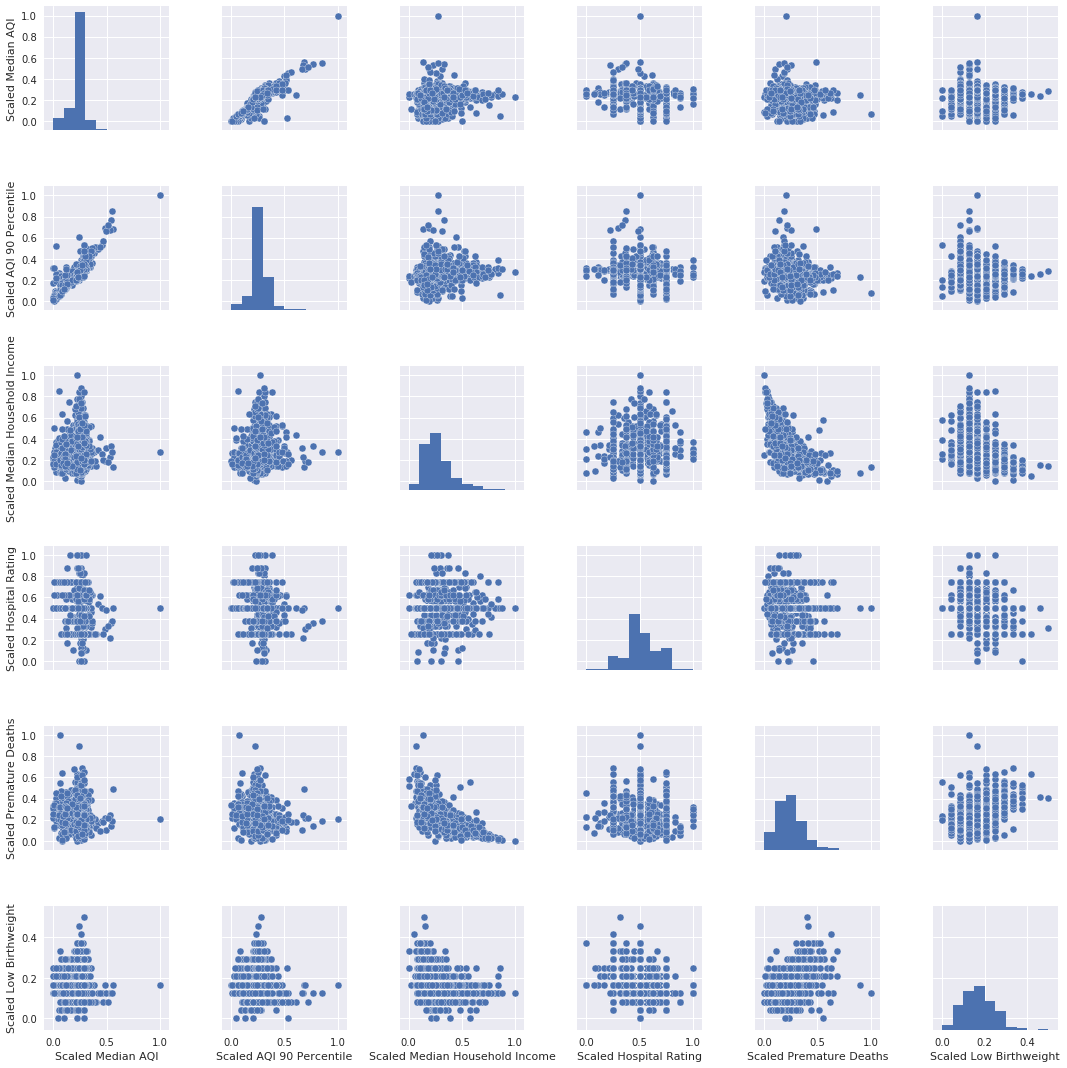

In [15]:
sns.pairplot(data_frame_transposed)

#### Calculating correlations
##### Pearson, Kendall, and Spearman correlations are different methods of calculating similar data.
##### Each is relevant for our data.  Though they are different they all report similar results.

In [16]:
#Calculate correlations
p_correlations = data_frame_transposed.corr('pearson')
k_correlations = data_frame_transposed.corr('kendall')
s_correlations = data_frame_transposed.corr('spearman')
p_correlations

,Scaled Median AQI,Scaled AQI 90 Percentile,Scaled Median Household Income,Scaled Hospital Rating,Scaled Premature Deaths,Scaled Low Birthweight
Scaled Median AQI,1.000000,0.830119,0.106844,-0.105286,-0.072364,0.079440
Scaled AQI 90 Percentile,0.830119,1.000000,0.139446,-0.088079,-0.147447,-0.031293
Scaled Median Household Income,0.106844,0.139446,1.000000,0.079197,-0.639638,-0.303323
Scaled Hospital Rating,-0.105286,-0.088079,0.079197,1.000000,-0.149845,-0.213605
Scaled Premature Deaths,-0.072364,-0.147447,-0.639638,-0.149845,1.000000,0.474733
Scaled Low Birthweight,0.079440,-0.031293,-0.303323,-0.213605,0.474733,1.000000


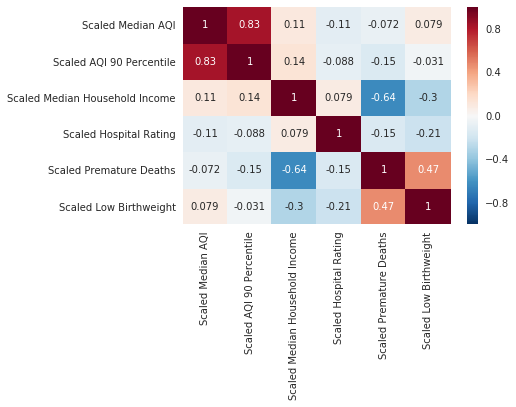

In [17]:
# plot the heatmap for Pearson correlations
sns.heatmap(p_correlations, annot=True)

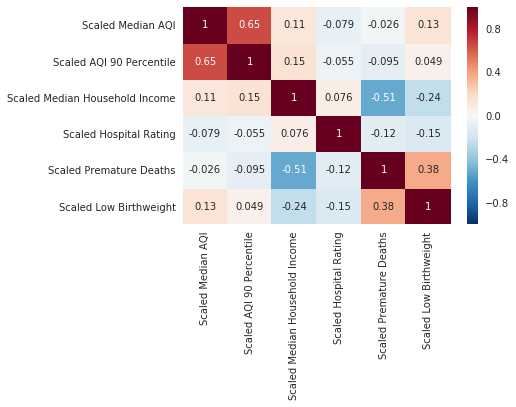

In [18]:
# plot the heatmap Kendall correlations
sns.heatmap(k_correlations, annot=True)

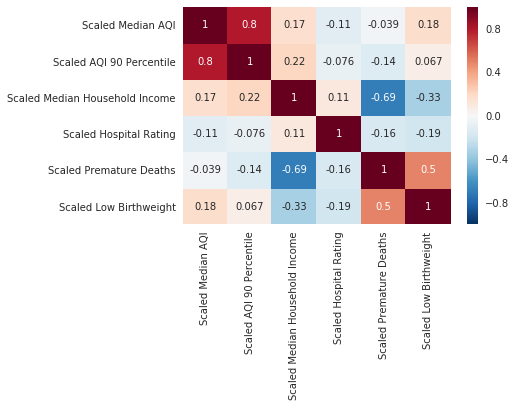

In [19]:
# plot the heatmap Spearman correlations
sns.heatmap(s_correlations, annot=True)

### Linear Regression starts here
#### Create the lists, then test them against the linear regression model.  Output a plot of all figures.
##### plots show Y test vs Y model predictions

X values are known, Y values are predicted


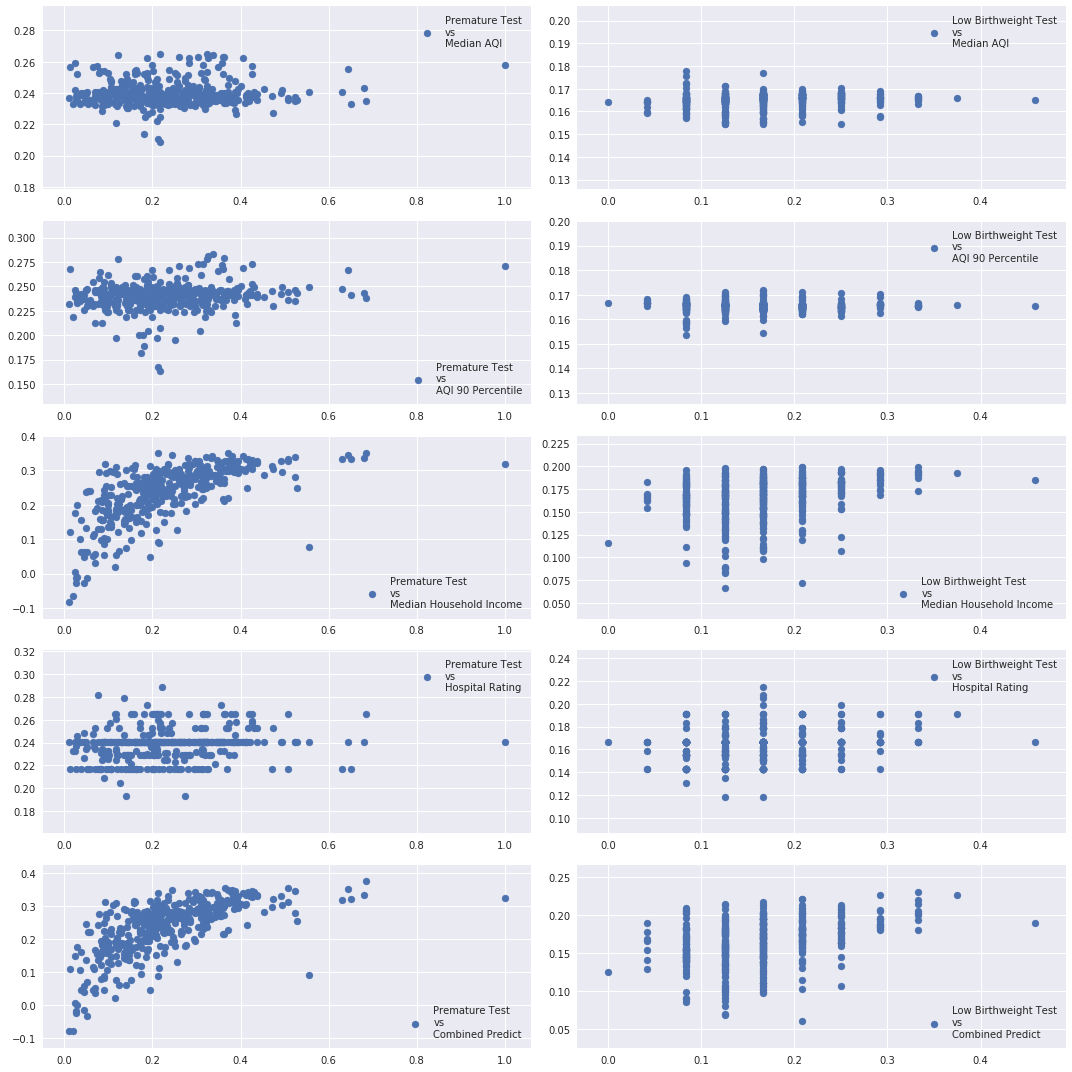

In [27]:
#Building testing lists
x_sma = data_frame_transposed[['Scaled Median AQI']]
x_sa90p = data_frame_transposed[['Scaled AQI 90 Percentile']]
x_smhi = data_frame_transposed[['Scaled Median Household Income']]
x_hr = data_frame_transposed[['Scaled Hospital Rating']]
x_combined = data_frame_transposed[['Scaled Median AQI','Scaled AQI 90 Percentile','Scaled Median Household Income','Scaled Hospital Rating']]
Y1 = data_frame_transposed[['Scaled Premature Deaths']]
Y2 = data_frame_transposed[['Scaled Low Birthweight']]

#set plot sizes to something more reasonable
plt.figure(figsize=(15, 15)) 

#building and test data
#Scaled Median AQI vs Scaled Premature Deaths
X_train_smap, X_test_smap, y_train_smap, y_test_smap = sklearn.model_selection.train_test_split(
    x_sma, Y1, test_size=0.4, random_state=101)
lm_smap = LinearRegression()
lm_smap.fit(X_train_smap,y_train_smap)
predictions_smap = lm_smap.predict(X_test_smap)
plt.subplot(5, 2, 1)
plt.scatter(y_test_smap, predictions_smap, label='Premature Test\nvs\nMedian AQI')
plt.legend(loc='best')

#Scaled Median AQI vs Low Birthweight
X_train_smab, X_test_smab, y_train_smab, y_test_smab = sklearn.model_selection.train_test_split(
    x_sma, Y2, test_size=0.4, random_state=101)
lm_smab = LinearRegression()
lm_smab.fit(X_train_smab,y_train_smab)
predictions_smab = lm_smab.predict(X_test_smab)
plt.subplot(5, 2, 2)
plt.scatter(y_test_smab, predictions_smab, label='Low Birthweight Test\nvs\nMedian AQI')
plt.legend(loc='best')

#Scaled AQI 90 Percentile vs Scaled Premature Deaths
X_train_sa90pp, X_test_sa90pp, y_train_sa90pp, y_test_sa90pp = sklearn.model_selection.train_test_split(
    x_sa90p, Y1, test_size=0.4, random_state=101)
lm_sa90pp = LinearRegression()
lm_sa90pp.fit(X_train_sa90pp,y_train_sa90pp)
predictions_sa90pp = lm_sa90pp.predict(X_test_sa90pp)
plt.subplot(5, 2, 3)
plt.scatter(y_test_sa90pp, predictions_sa90pp, label='Premature Test\nvs\nAQI 90 Percentile')
plt.legend(loc='best')

#Scaled AQI 90 Percentile vs Low Birthweight
X_train_sa90pb, X_test_sa90pb, y_train_sa90pb, y_test_sa90pb = sklearn.model_selection.train_test_split(
    x_sa90p, Y2, test_size=0.4, random_state=101)
lm_sa90pb = LinearRegression()
lm_sa90pb.fit(X_train_sa90pb,y_train_sa90pb)
predictions_sa90pb = lm_sa90pb.predict(X_test_sa90pb)
plt.subplot(5, 2, 4)
plt.scatter(y_test_sa90pb, predictions_sa90pb, label='Low Birthweight Test\nvs\nAQI 90 Percentile')
plt.legend(loc='best')

#Scaled Median Household Income vs Scaled Premature Deaths
X_train_smhip, X_test_smhip, y_train_smhip, y_test_smhip = sklearn.model_selection.train_test_split(
    x_smhi, Y1, test_size=0.4, random_state=101)
lm_smhip = LinearRegression()
lm_smhip.fit(X_train_smhip,y_train_smhip)
predictions_smhip = lm_smhip.predict(X_test_smhip)
plt.subplot(5, 2, 5)
plt.scatter(y_test_smhip, predictions_smhip, label='Premature Test\nvs\nMedian Household Income')
plt.legend(loc='best')

#Scaled Median Household Income vs Low Birthweight
X_train_smhib, X_test_smhib, y_train_smhib, y_test_smhib = sklearn.model_selection.train_test_split(
    x_smhi, Y2, test_size=0.4, random_state=101)
lm_smhib = LinearRegression()
lm_smhib.fit(X_train_smhib,y_train_smhib)
predictions_smhib = lm_smhib.predict(X_test_smhib)
plt.subplot(5, 2, 6)
plt.scatter(y_test_smhib, predictions_smhib, label='Low Birthweight Test\nvs\nMedian Household Income ')
plt.legend(loc='best')

#Scaled Hospital Rating vs Scaled Premature Deaths
X_train_hrp, X_test_hrp, y_train_hrp, y_test_hrp = sklearn.model_selection.train_test_split(
    x_hr, Y1, test_size=0.4, random_state=101)
lm_hrp = LinearRegression()
lm_hrp.fit(X_train_hrp,y_train_hrp)
predictions_hrp = lm_hrp.predict(X_test_hrp)
plt.subplot(5, 2, 7)
plt.scatter(y_test_hrp, predictions_hrp, label='Premature Test\nvs\nHospital Rating')
plt.legend(loc='best')

#Scaled Hospital Rating vs Low Birthweight
X_train_hrb, X_test_hrb, y_train_hrb, y_test_hrb = sklearn.model_selection.train_test_split(
    x_hr, Y2, test_size=0.4, random_state=101)
lm_hrb = LinearRegression()
lm_hrb.fit(X_train_hrb,y_train_hrb)
predictions_hrb = lm_hrb.predict(X_test_hrb)
plt.subplot(5, 2, 8)
plt.scatter(y_test_hrb, predictions_hrb, label='Low Birthweight Test\nvs\nHospital Rating')
plt.legend(loc='best')

#Scaled combined vs Scaled Premature Deaths
X_train_combinedp, X_test_combinedp, y_train_combinedp, y_test_combinedp = sklearn.model_selection.train_test_split(
    x_combined, Y1, test_size=0.4, random_state=101)
lm_combinedp = LinearRegression()
lm_combinedp.fit(X_train_combinedp,y_train_combinedp)
predictions_combinedp = lm_combinedp.predict(X_test_combinedp)
plt.subplot(5, 2, 9)
plt.scatter(y_test_combinedp, predictions_combinedp, label='Premature Test\nvs\nCombined Predict')
plt.legend(loc='best')

#Scaled combined vs Low Birthweight
X_train_combinedb, X_test_combinedb, y_train_combinedb, y_test_combinedb = sklearn.model_selection.train_test_split(
    x_combined, Y2, test_size=0.4, random_state=101)
lm_combinedb = LinearRegression()
lm_combinedb.fit(X_train_combinedb,y_train_combinedb)
predictions_combinedb = lm_combinedb.predict(X_test_combinedb)
plt.subplot(5, 2, 10)
plt.scatter(y_test_combinedb, predictions_combinedb, label='Low Birthweight Test\nvs\nCombined Predict')
plt.legend(loc='best')

print('X values are known, Y values are predicted')
plt.tight_layout()
plt.show()

#### Zooming in on the Premature Test vs Median Household Income plot

[-0.1, 0.5, -0.1, 0.5]

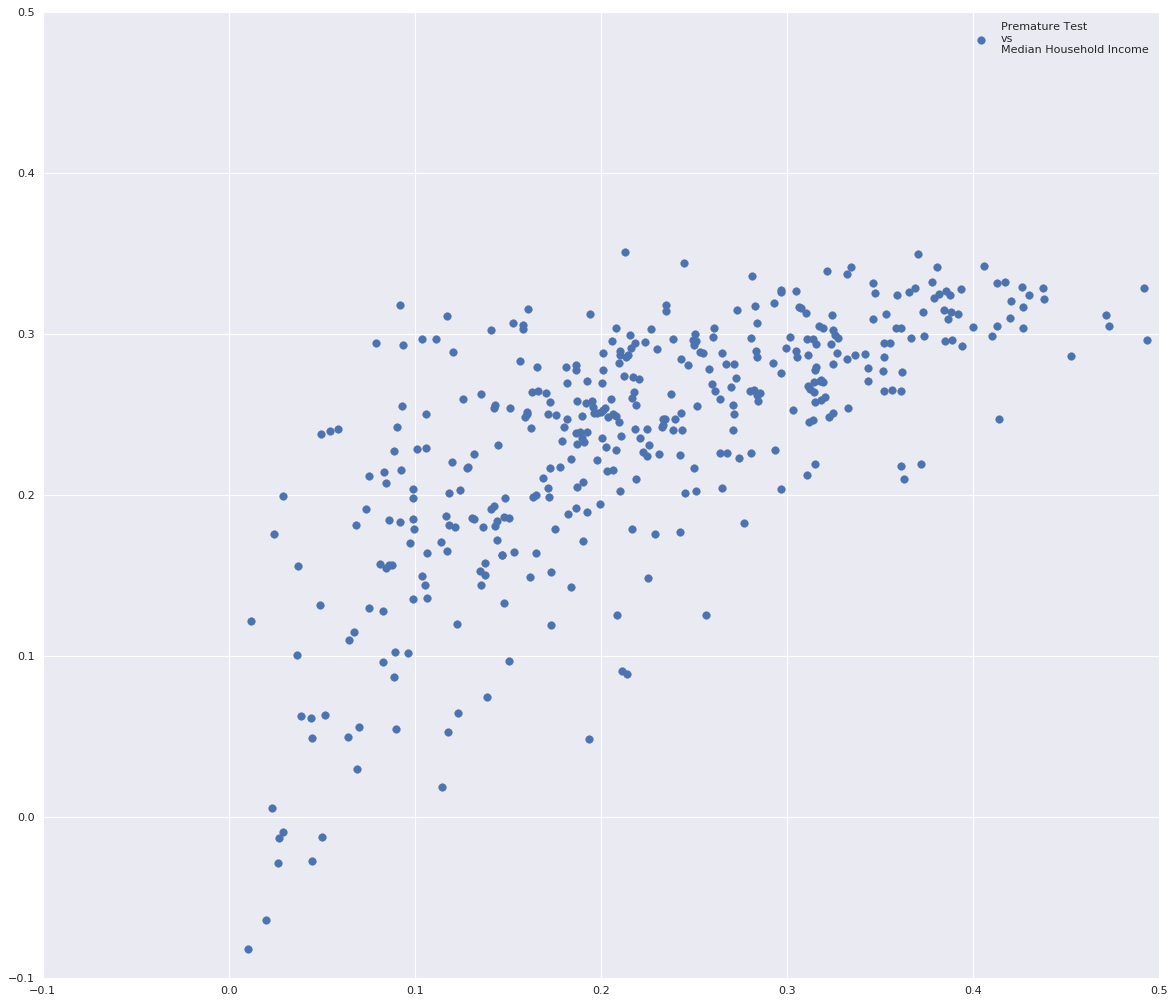

In [21]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(y_test_smhip, predictions_smhip, label='Premature Test\nvs\nMedian Household Income')

plt.legend(loc='best')
plt.axis([-.1,.5,-.1,.5])

#### Showing linear regression against the X/Y data instead of Y/Y data
##### scatter plots are test x/y data
##### line plots are test x/predicted y data

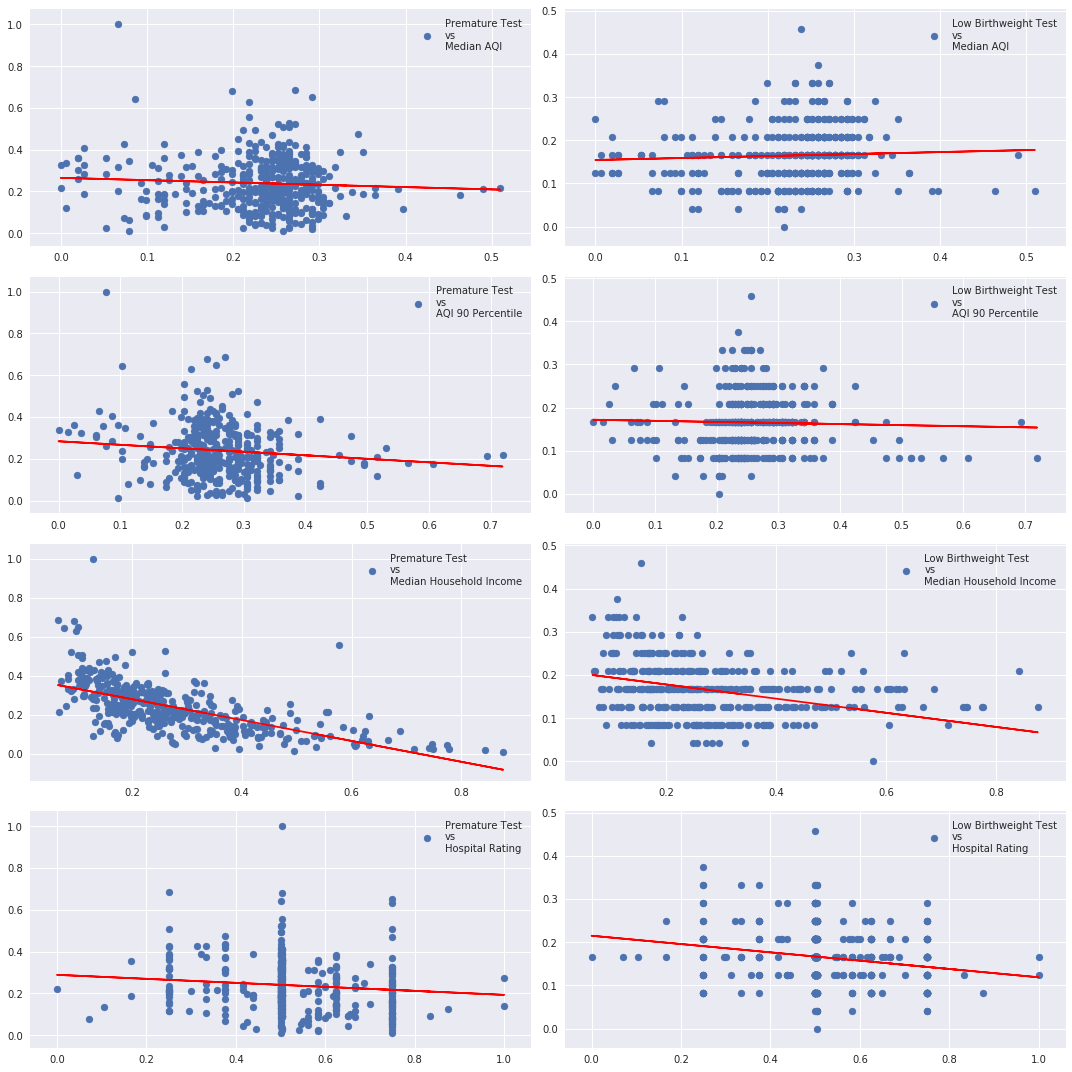

In [22]:
#set plot sizes to something more reasonable
plt.figure(figsize=(15, 15)) 

#plotting test data
#Scaled Median AQI vs Scaled Premature Deaths
plt.subplot(4, 2, 1)
plt.scatter(X_test_smap, y_test_smap, label='Premature Test\nvs\nMedian AQI')
plt.plot(X_test_smap, predictions_smap, color='red')
plt.legend(loc='best')

#Scaled Median AQI vs Low Birthweight
plt.subplot(4, 2, 2)
plt.scatter(X_test_smab, y_test_smab, label='Low Birthweight Test\nvs\nMedian AQI')
plt.plot(X_test_smab, predictions_smab, color='red')
plt.legend(loc='best')

#Scaled AQI 90 Percentile vs Scaled Premature Deaths
plt.subplot(4, 2, 3)
plt.scatter(X_test_sa90pp, y_test_sa90pp, label='Premature Test\nvs\nAQI 90 Percentile')
plt.plot(X_test_sa90pp, predictions_sa90pp, color='red')
plt.legend(loc='best')

#Scaled AQI 90 Percentile vs Low Birthweight
plt.subplot(4, 2, 4)
plt.scatter(X_test_sa90pb, y_test_sa90pb, label='Low Birthweight Test\nvs\nAQI 90 Percentile')
plt.plot(X_test_sa90pb, predictions_sa90pb, color='red')
plt.legend(loc='best')

#Scaled Median Household Income vs Scaled Premature Deaths
plt.subplot(4, 2, 5)
plt.scatter(X_test_smhip, y_test_smhip, label='Premature Test\nvs\nMedian Household Income')
plt.plot(X_test_smhip, predictions_smhip, color='red')
plt.legend(loc='best')

#Scaled Median Household Income vs Low Birthweight
plt.subplot(4, 2, 6)
plt.scatter(X_test_smhib, y_test_smhib, label='Low Birthweight Test\nvs\nMedian Household Income')
plt.plot(X_test_smhib, predictions_smhib, color='red')
plt.legend(loc='best')

#Scaled Hospital Rating vs Scaled Premature Deaths
plt.subplot(4, 2, 7)
plt.scatter(X_test_hrp, y_test_hrp, label='Premature Test\nvs\nHospital Rating')
plt.plot(X_test_hrp, predictions_hrp, color='red')
plt.legend(loc='best')

#Scaled Hospital Rating vs Low Birthweight
plt.subplot(4, 2, 8)
plt.scatter(X_test_hrb, y_test_hrb, label='Low Birthweight Test\nvs\nHospital Rating')
plt.plot(X_test_hrb, predictions_hrb, color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [23]:
print('Premature Test vs Median AQI\nR^2 value: ',r2_score(y_test_smap,predictions_smap),'\nMean Squared Error: ',mean_squared_error(y_test_smap,predictions_smap),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_smap,predictions_smap)),'\n')
print('Low Birthweight Test vs Median AQI\nR^2 value: ',r2_score(y_test_smab,predictions_smab),'\nMean Squared Error: ',mean_squared_error(y_test_smab,predictions_smab),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_smab,predictions_smab)),'\n')
print('\nPremature Test vs AQI 90 Percentile\nR^2 value: ',r2_score(y_test_sa90pp,predictions_sa90pp),'\nMean Squared Error: ',mean_squared_error(y_test_sa90pp,predictions_sa90pp),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_sa90pp,predictions_sa90pp)),'\n')
print('Low Birthweight Test vs AQI 90 Percentile\nR^2 value: ',r2_score(y_test_sa90pb,predictions_sa90pb),'\nMean Squared Error: ',mean_squared_error(y_test_sa90pb,predictions_sa90pb),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_sa90pb,predictions_sa90pb)),'\n')
print('\nPremature Test vs Median Household Income\nR^2 value: ',r2_score(y_test_smhip,predictions_smhip),'\nMean Squared Error: ',mean_squared_error(y_test_smhip,predictions_smhip),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_smhip,predictions_smhip)),'\n')
print('Low Birthweight Test vs Median Household Income\nR^2 value: ',r2_score(y_test_smhib,predictions_smhib),'\nMean Squared Error: ',mean_squared_error(y_test_smhib,predictions_smhib),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_smhib,predictions_smhib)),'\n')
print('\nPremature Test vs Hospital Rating\nR^2 value: ',r2_score(y_test_hrp,predictions_hrp),'\nMean Squared Error: ',mean_squared_error(y_test_hrp,predictions_hrp),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_hrp,predictions_hrp)),'\n')
print('Low Birthweight Test vs Hospital Rating\nR^2 value: ',r2_score(y_test_hrb,predictions_hrb),'\nMean Squared Error: ',mean_squared_error(y_test_hrb,predictions_hrb),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_hrb,predictions_hrb)),'\n')
print('\nPremature Test vs Combined Predict\nR^2 value: ',r2_score(y_test_combinedp,predictions_combinedp),'\nMean Squared Error: ',mean_squared_error(y_test_combinedp,predictions_combinedp),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_combinedp,predictions_combinedp)),'\n')
print('Low Birthweight Test vs Combined Predict\nR^2 value: ',r2_score(y_test_combinedb,predictions_combinedb),'\nMean Squared Error: ',mean_squared_error(y_test_combinedb,predictions_combinedb),'\nRoot MSE: ',sqrt(mean_squared_error(y_test_combinedb,predictions_combinedb)),'\n')


Premature Test vs Median AQI
R^2 value:  0.0028954365725587516 
Mean Squared Error:  0.015588857424270975 
Root MSE:  0.12485534599796268 

Low Birthweight Test vs Median AQI
R^2 value:  0.010576813080859782 
Mean Squared Error:  0.004001199474535355 
Root MSE:  0.06325503517140241 


Premature Test vs AQI 90 Percentile
R^2 value:  0.023672485613066785 
Mean Squared Error:  0.01526402644157421 
Root MSE:  0.12354766870149436 

Low Birthweight Test vs AQI 90 Percentile
R^2 value:  0.000701530019089458 
Mean Squared Error:  0.004041134840837694 
Root MSE:  0.0635699208811659 


Premature Test vs Median Household Income
R^2 value:  0.4120935298083195 
Mean Squared Error:  0.009191403267799244 
Root MSE:  0.09587180642816345 

Low Birthweight Test vs Median Household Income
R^2 value:  0.06906433241167009 
Mean Squared Error:  0.0037646775952149343 
Root MSE:  0.06135696859538397 


Premature Test vs Hospital Rating
R^2 value:  0.026949510798084497 
Mean Squared Error:  0.01521279302006685

### Run a Monte Carlo Simulation for Linear Regression

In [24]:
#get all the data into a dictionary and a list
#Starting the database connection and setting up default values
mydb = mysql.connector.connect(
  host="localhost",
  user="i501fa18_group5",
  passwd="*85E!4LfLQbQ",
  database="i501fa18_group5"
)

#blank arrays for classes
combinedDict = {}
combinedList = []
hospitalDict = {}

#query to get the hospital_rating and create a hospitalDict.  Fewer FIP codes reported this statistic, so we are running this seperately to not confuse the other outputs.
cursor = mydb.cursor()
query = ("SELECT avg(hospital_rating), fip FROM CombinedData group by fip HAVING AVG(hospital_rating) >= 0")
cursor.execute(query)
for row in cursor:
    hospitalDict[row[1]] = row[0]

#query for FipCodeToCounty, build class dictionary
query = ("SELECT fip, state, county, median_aqi, AQI_ninety_percentile, median_household_income_value, premature_deaths, population_estimate_value, low_birthweight FROM CombinedData where premature_deaths is not NULL and low_birthweight is not NULL")
cursor.execute(query)
for row in cursor:
    #adding in the hospital rating value
    #appending the average of all other FIP codes to remove NULLS
    hr = float(3.0131)
    if(hospitalDict.get(row[0])):
        hr = float(hospitalDict.get(row[0]))
    currentFip = FipCodeCombineStats(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],hr)
    combinedDict[row[0]] = currentFip
    combinedList.append(currentFip)

#close the database when you are done with it
mydb.close()

[41, 50, 57427, 3.0]
[0.4238410596026489, 0.4948979591836738, 0.2972292964315303, 0.5370249999999996]


In [26]:
#linear regression running below
stats,premature_weights, low_weights = [],[[], [], [], []],[[], [], [], []] #3 total weights possible
premature_MSE = 0
low_MSE = 0
numTrials = 200

for i in range(numTrials):
    training, testSet = divide80_20(combinedList) #divide the training and test data sets
    featureVecs = [[],[],[],[]]
    labels = [[],[]]
    predictionData = [[],[],[],[],[],[]]
    xVals = [[],[],[]]
    for fip in training:
        featureVecs[0].append(fip.scaledFeatureVec)
        featureVecs[1].append(fip.scaledFeatureVec[0])
        featureVecs[2].append(fip.scaledFeatureVec[1])
        featureVecs[3].append(fip.scaledFeatureVec[2])
        labels[0].append(fip.scaled_premature_deaths)
        labels[1].append(fip.scaled_low_birthweight)

    for fip in testSet:
        predictionData[0].append(fip.scaledFeatureVec)
        predictionData[1].append(fip.scaledFeatureVec[0])
        predictionData[2].append(fip.scaledFeatureVec[1])
        predictionData[3].append(fip.scaledFeatureVec[2])
        predictionData[4].append(fip.scaled_premature_deaths)
        predictionData[5].append(fip.scaled_low_birthweight)
    
    #find weights for premature deaths dataset
    regr_premature = sklearn.linear_model.LinearRegression()
    regr_premature.fit(featureVecs[0],labels[0])
    for i in range(len(FipCodeCombineStats.features)):  #switch features or scaledFeatures not really necessary as they are the same length
        #print('Feature weight of: ' + FipCodeCombineStats.features[i] + ' ' + str(regr.coef_[i]))
        premature_weights[i].append(regr_premature.coef_[i])
        
    #find weights for low birthweight dataset
    regr_low = sklearn.linear_model.LinearRegression()
    regr_low.fit(featureVecs[0],labels[1])
    for i in range(len(FipCodeCombineStats.features)):  #switch features or scaledFeatures not really necessary as they are the same length
        #print('Feature weight of: ' + FipCodeCombineStats.features[i] + ' ' + str(regr_low.coef_[i]))
        low_weights[i].append(regr_low.coef_[i])
    
    # Make predictions using the testing sets
    premature_predictions = regr_premature.predict(predictionData[0])
    low_predictions = regr_low.predict(predictionData[0])
    premature_MSE += mean_squared_error(predictionData[1], premature_predictions)
    low_MSE += mean_squared_error(predictionData[1], low_predictions)
    
print('\nAverages for', numTrials, 'trials')
print('Premature Deaths: ')
for feature in range(len(premature_weights)):
    featureMean = sum(premature_weights[feature])/numTrials
    featureStd = stdDev(premature_weights[feature])
    print(' Mean weight of', FipCodeCombineStats.features[feature],
         '=', str(round(featureMean, 3)) + ',',
         '95% confidence interval =', round(1.96*featureStd, 3))
print(' Average Mean Squared Error over trials: ' + str(premature_MSE/numTrials))

print('\nLow Birth Weights: ')
for feature in range(len(low_weights)):
    featureMean = sum(low_weights[feature])/numTrials
    featureStd = stdDev(low_weights[feature])
    print(' Mean weight of', FipCodeCombineStats.features[feature],
         '=', str(round(featureMean, 8)) + ',',
         '95% confidence interval =', round(1.96*featureStd, 8))
print(' Average Mean Squared Error over trials: ' + str(low_MSE/numTrials))


Averages for 200 trials
Premature Deaths: 
 Mean weight of Median AQI = 0.17, 95% confidence interval = 0.045
 Mean weight of AQI 90 Percentile = -0.263, 95% confidence interval = 0.03
 Mean weight of Median Household Income = -0.52, 95% confidence interval = 0.011
 Mean weight of Hospital Rating = -0.061, 95% confidence interval = 0.011
 Average Mean Squared Error over trials: 0.020642578222749716

Low Birth Weights: 
 Mean weight of Median AQI = 0.33182905, 95% confidence interval = 0.03623814
 Mean weight of AQI 90 Percentile = -0.27629504, 95% confidence interval = 0.02577187
 Mean weight of Median Household Income = -0.13503469, 95% confidence interval = 0.0077288
 Mean weight of Hospital Rating = -0.09068045, 95% confidence interval = 0.00695141
 Average Mean Squared Error over trials: 0.01911496864972661
